## Examen Final
- **Autor**: John Davids Sovero Cubillas (u202115065)

In [157]:
# Importando librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import optuna
from optuna import Trial
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
import pickle
import joblib
pd.set_option('display.max_columns', None)
warnings.simplefilter(action="ignore")

In [158]:
# Leyendo el dataset
df = pd.read_csv('tested.csv')

In [159]:
# Ver las primeras columnas y sus dimensiones
print(df.shape)
df.head()

(418, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [160]:
# Verificando información básica
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [161]:
# Viendo estadísticas básicas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Survived,418.0,0.363636,0.481622,0.00,0.0000,0.0000,1.00,1.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


In [162]:
# Creamos una función para visualizar los valores nulos y su porcentaje en el data set
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values
missing(df)

,Missing_Number,Missing_Percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


Notamos que la columna Age tiene 20.5%, Cabin tiene 78.2% y Fare tiene 0.23% de valores nulos

In [163]:
# Verificamos cantidad de valores duplicados
df.duplicated().value_counts()

False    418
Name: count, dtype: int64

Verificamos que no existen valores duplicados

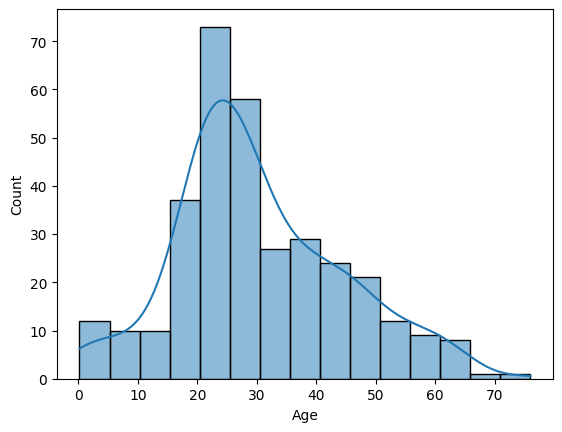

In [164]:
# Graficamos la variable Age para ver su distribucion
sns.histplot(df['Age'], kde=True)
plt.show()

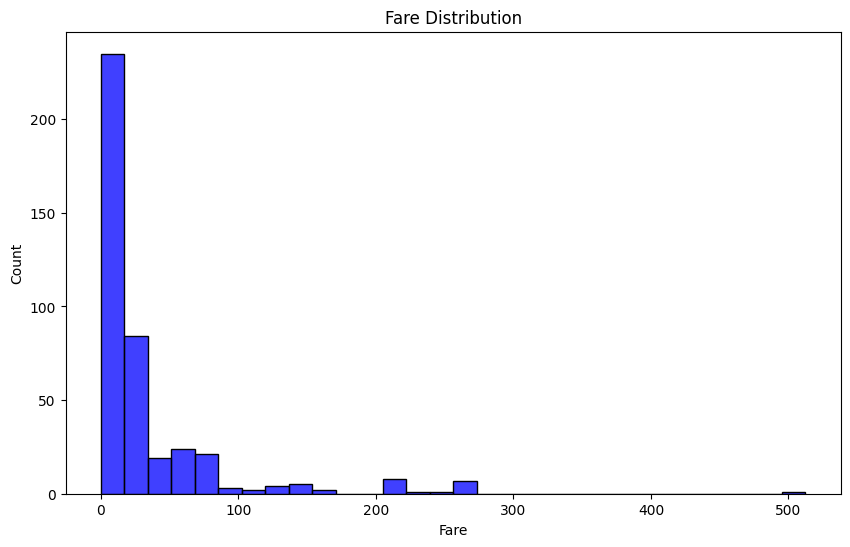

In [165]:
# Graficamos la variable Fare para ver su distribucion
plt.figure(figsize=(10,6))
sns.histplot(df['Fare'], bins=30, color='blue')
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show()

In [166]:
# Visualizaremos todos los valores únicos de las variables categóricas
for col in df.select_dtypes(include='object'):
    print(f'{col :-<50} {df[col].unique()}')

Name---------------------------------------------- ['Kelly, Mr. James' 'Wilkes, Mrs. James (Ellen Needs)'
 'Myles, Mr. Thomas Francis' 'Wirz, Mr. Albert'
 'Hirvonen, Mrs. Alexander (Helga E Lindqvist)'
 'Svensson, Mr. Johan Cervin' 'Connolly, Miss. Kate'
 'Caldwell, Mr. Albert Francis'
 'Abrahim, Mrs. Joseph (Sophie Halaut Easu)' 'Davies, Mr. John Samuel'
 'Ilieff, Mr. Ylio' 'Jones, Mr. Charles Cresson'
 'Snyder, Mrs. John Pillsbury (Nelle Stevenson)' 'Howard, Mr. Benjamin'
 'Chaffee, Mrs. Herbert Fuller (Carrie Constance Toogood)'
 'del Carlo, Mrs. Sebastiano (Argenia Genovesi)' 'Keane, Mr. Daniel'
 'Assaf, Mr. Gerios' 'Ilmakangas, Miss. Ida Livija'
 'Assaf Khalil, Mrs. Mariana (Miriam")"' 'Rothschild, Mr. Martin'
 'Olsen, Master. Artur Karl' 'Flegenheim, Mrs. Alfred (Antoinette)'
 'Williams, Mr. Richard Norris II'
 'Ryerson, Mrs. Arthur Larned (Emily Maria Borie)'
 'Robins, Mr. Alexander A' 'Ostby, Miss. Helene Ragnhild'
 'Daher, Mr. Shedid' 'Brady, Mr. John Bertram' 'Samaan, Mr. Eli

In [167]:
# Reemplazaremos los valores nulos de la variable Age con la media
df['Age'] = df['Age'].fillna(df['Age'].mean())

# Reemplazaremos los valores nulos de la variable Fare con la media
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

In [168]:
# Eliminamos la columna Cabin por tener mucha cantidad de valores nulos
df.drop('Cabin', axis=1, inplace=True)

In [169]:
# Verificamos las columnas categóricas
df.select_dtypes(include='object').columns

Index(['Name', 'Sex', 'Ticket', 'Embarked'], dtype='object')

In [170]:
# Separamos las columnas en nominal y ordinal, no consideramos name ya que no se usará para el entrenamiento del modelo
nominal = ['Sex', 'Embarked']

Notamos que no existe ninguna variable ordinal

In [171]:
# One Hot Encoding para las variable nominales
onehotenc = OneHotEncoder(cols = nominal)

In [172]:
# Dividimos la data en X y Y
X = df.drop(['Survived', 'Name', 'PassengerId', 'Ticket'], axis=1)
y = df['Survived']

In [173]:
# Creamos un pipeline para preprocesar la data
# We create a pipeline to preprocess the data
nominal_transformer = Pipeline(
    steps=[
        ('nominal', onehotenc)
    ]
)

mapper = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('mapper', mapper),
        ('scaler', StandardScaler())
    ]
)

In [174]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.50000,0,0,7.8292,Q
1,3,female,47.00000,1,0,7.0000,S
2,2,male,62.00000,0,0,9.6875,Q
3,3,male,27.00000,0,0,8.6625,S
4,3,female,22.00000,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,30.27259,0,0,8.0500,S
414,1,female,39.00000,0,0,108.9000,C
415,3,male,38.50000,0,0,7.2500,S
416,3,male,30.27259,0,0,8.0500,S


In [189]:
for col in X.select_dtypes(include='object'):
    print(f'{col :-<50} {X[col].unique()}')

Sex----------------------------------------------- ['male' 'female']
Embarked------------------------------------------ ['Q' 'S' 'C']


In [175]:
# Converitr la data a un Dataframe despues de preprocesarlo
encoded = pipeline.fit_transform(X)
X_transformed = pd.DataFrame(encoded, columns=pipeline.named_steps['mapper'].get_feature_names_out())
print(X_transformed.shape)
X_transformed.head()

(418, 10)


,nominal__Sex_1,nominal__Sex_2,nominal__Embarked_1,nominal__Embarked_2,nominal__Embarked_3,remainder__Pclass,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare
0,0.755929,-0.755929,2.843757,-1.350676,-0.568142,0.873482,0.334993,-0.499470,-0.400248,-0.498407
1,-1.322876,1.322876,-0.351647,0.740370,-0.568142,0.873482,1.325530,0.616992,-0.400248,-0.513274
2,0.755929,-0.755929,2.843757,-1.350676,-0.568142,-0.315819,2.514175,-0.499470,-0.400248,-0.465088
3,0.755929,-0.755929,-0.351647,0.740370,-0.568142,0.873482,-0.259330,-0.499470,-0.400248,-0.483466
4,-1.322876,1.322876,-0.351647,0.740370,-0.568142,0.873482,-0.655545,0.616992,0.619896,-0.418471


In [190]:
X_transformed.columns

Index(['nominal__Sex_1', 'nominal__Sex_2', 'nominal__Embarked_1',
       'nominal__Embarked_2', 'nominal__Embarked_3', 'remainder__Pclass',
       'remainder__Age', 'remainder__SibSp', 'remainder__Parch',
       'remainder__Fare'],
      dtype='object')

In [176]:
# Guardamos el pipeline
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [177]:
# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((334, 10), (84, 10), (334,), (84,))

### 1. Aplique por lo menos dos métodos de clasificación a los datos, utilice como variable target la columna Survived.

In [178]:
# Creamos un modelo de Random Forest básico
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [179]:
# Vemos el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [180]:
# Creamos un modelo de Regresión Logística básico
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_logistic = lr.predict(X_test)

In [181]:
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



### 2. Utilice la librería sklearn-genetic-opt y/o optuna para la optimización de hiperparametros, compare los resultados de los modelos.

In [182]:
# Utilizamos la optimización de hiperparámetros con Sklearn-genetic-opt
rf_optimized = RandomForestClassifier()

param_grid = {
    'n_estimators': Integer(100, 300),
    'max_features': Categorical(['sqrt', 'log2']),
    'max_depth': Integer(2, 30),
    'criterion': Categorical(['gini', 'entropy']),
}

# Creamos las configuraciones iniciales
warm_start_configs = [
           {"min_weight_fraction_leaf": 0.02, "bootstrap": True, "max_depth": None, "n_estimators": 100},
           {"min_weight_fraction_leaf": 0.4, "bootstrap": True, "max_depth": 5, "n_estimators": 200},
    ]

cv = StratifiedKFold(n_splits=3, shuffle=True)

evolved_estimator = GASearchCV(
    estimator=rf_optimized,
    cv=cv,
    scoring='accuracy',
    population_size=20,
    generations=35,
    param_grid=param_grid,
    n_jobs=-1,
    verbose=True,
    use_cache=True,
    warm_start_configs=warm_start_configs,
    keep_top_k=4
)

# Entrenamos y optimizamos el modelo
evolved_estimator.fit(X_train, y_train)
# Visualizamos los mejores hiperparámetros
print(evolved_estimator.best_params_)
# Predecimos con el modelo optimizado
y_predict_ga = evolved_estimator.predict(X_test)
print(accuracy_score(y_test, y_predict_ga))

# Saved metadata for further analysis
print("Stats achieved in each generation: ", evolved_estimator.history)
print("Best k solutions: ", evolved_estimator.hof)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	20    	1      	0          	1          	1          
1  	40    	1      	0          	1          	1          
2  	40    	1      	0          	1          	1          
3  	40    	1      	0          	1          	1          
4  	40    	1      	0          	1          	1          
5  	40    	1      	0          	1          	1          
6  	40    	1      	0          	1          	1          
7  	40    	1      	0          	1          	1          
8  	40    	1      	0          	1          	1          
9  	40    	1      	0          	1          	1          
10 	40    	1      	0          	1          	1          
11 	40    	1      	0          	1          	1          
12 	40    	1      	0          	1          	1          
13 	40    	1      	0          	1          	1          
14 	40    	1      	0          	1          	1          
15 	40    	1      	0          	1          	1          
16 	40    	1      	0          	1          	1          
17 	40    

In [183]:
# Buscamos los mejores hipeparámetros con Regresión Logística

# Definimos el espacio de búsqueda de los hiperparámetros
param_grid_lr = {
    "C": Continuous(0.01, 100, distribution="log-uniform"),
    "solver": Categorical(["liblinear", "saga"]),
    "max_iter": Integer(100, 500),
}

# Creamos el modelo de LogisticRegression
lr = LogisticRegression(random_state=42)

# Configuramos la búsqueda genética para LogisticRegression
genetic_lr = GASearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    population_size=20,
    generations=10
)

# Entrenamos búsqueda genética para LogisticRegression
genetic_lr.fit(X_train, y_train)

# Ver mejores hiperparámetros para LogisticRegression
print("Mejores hiperparámetros para LogisticRegression:", genetic_lr.best_params_)
print("Mejor puntuación:", genetic_lr.best_score_)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	20    	1      	0          	1          	1          
1  	40    	1      	0          	1          	1          
2  	40    	1      	0          	1          	1          
3  	40    	1      	0          	1          	1          
4  	40    	1      	0          	1          	1          
5  	40    	1      	0          	1          	1          
6  	40    	1      	0          	1          	1          
7  	40    	1      	0          	1          	1          
8  	40    	1      	0          	1          	1          
9  	40    	1      	0          	1          	1          
10 	40    	1      	0          	1          	1          
Mejores hiperparámetros para LogisticRegression: {'C': 0.7708393504724187, 'solver': 'liblinear', 'max_iter': 319}
Mejor puntuación: 1.0


- Random Forest con Optuna

In [184]:
# Buscamos los mejores hiperparámetros con Optuna para Random Forest
def objective(trial):
    # Definimos los hiperparámetros a optimizar
    n_estimators = trial.suggest_int("n_estimators", 10, 500, step=20)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "random_state": 100
    }
    model = RandomForestClassifier(**params)    
    
    # Validamos el modelo con la métrica de precisión ponderada porque es un dataset con clases desbalanceadas en la columna objetivo
    cv_score = cross_val_score(model, X_train, y_train, scoring="precision_weighted", cv=5)
    mean_cv_precision = cv_score.mean()
    return mean_cv_precision

# Creamos el estudio para optimizar los hiperparámetros de Random Forest
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

print('Mejores hiperparámetros:', study_rf.best_params)
print('Mejor score de precisión ponderada:', study_rf.best_value)

[I 2024-11-26 16:33:37,282] A new study created in memory with name: no-name-221a67ed-16c6-47c1-b7a2-7a779cae88d0


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-26 16:33:46,404] Trial 11 finished with value: 1.0 and parameters: {'n_estimators': 110, 'max_depth': 13, 'min_samples_split': 4}. Best is trial 11 with value: 1.0.
[I 2024-11-26 16:33:47,868] Trial 8 finished with value: 1.0 and parameters: {'n_estimators': 130, 'max_depth': 7, 'min_samples_split': 8}. Best is trial 11 with value: 1.0.
[I 2024-11-26 16:33:49,690] Trial 9 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_split': 7}. Best is trial 11 with value: 1.0.
[I 2024-11-26 16:33:50,246] Trial 5 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 19, 'min_samples_split': 9}. Best is trial 11 with value: 1.0.
[I 2024-11-26 16:33:51,949] Trial 14 finished with value: 1.0 and parameters: {'n_estimators': 170, 'max_depth': 16, 'min_samples_split': 6}. Best is trial 11 with value: 1.0.
[I 2024-11-26 16:33:52,048] Trial 6 finished with value: 1.0 and parameters: {'n_estimators': 170, 'max_depth': 15, 'min_samp

- Regresión Logística con Optuna

In [185]:
# Buscamos los mejores hiperparámetros con Optuna para Regresión Logística
def objective(trial):
    # Definimos los hiperparámetros a optimizar
    C = trial.suggest_float("C", 0.001, 100.0, log=True)
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])
    max_iter = trial.suggest_int("max_iter", 100, 500)

    # Crear modelo con los parámetros sugeridos
    params = {
        "C": C,
        "solver": solver,
        "max_iter": max_iter,
        "random_state": 100
    }
    model = LogisticRegression(**params)
    
    # Validamos el modelo con la métrica de precisión ponderada porque es un dataset con clases desbalanceadas en la columna objetivo
    cv_score = cross_val_score(model, X_train, y_train, scoring="precision_weighted", cv=5, n_jobs=-1)
    mean_cv_precision = cv_score.mean()
    return mean_cv_precision

# Crear el estudio para optimizar los hiperparámetros de Regresión Logística
study_rl = optuna.create_study(direction="maximize")
study_rl.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

# Resultados
print('Mejores hiperparámetros:', study_rl.best_params)
print('Mejor score de precisión ponderada:', study_rl.best_value)

[I 2024-11-26 16:35:03,606] A new study created in memory with name: no-name-cd521e0d-d189-4a98-a07b-ab3496782ef5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-26 16:35:03,724] Trial 1 finished with value: 0.8808274579077171 and parameters: {'C': 0.002399504371595687, 'solver': 'saga', 'max_iter': 324}. Best is trial 1 with value: 0.8808274579077171.
[I 2024-11-26 16:35:03,748] Trial 0 finished with value: 1.0 and parameters: {'C': 0.010148593908869324, 'solver': 'saga', 'max_iter': 306}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:35:03,766] Trial 6 finished with value: 1.0 and parameters: {'C': 0.014075773446837287, 'solver': 'saga', 'max_iter': 306}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:35:03,768] Trial 3 finished with value: 0.8328701240177212 and parameters: {'C': 0.002247576988788054, 'solver': 'saga', 'max_iter': 483}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:35:03,769] Trial 5 finished with value: 1.0 and parameters: {'C': 33.93166011218752, 'solver': 'saga', 'max_iter': 442}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:35:03,773] Trial 4 finished with value: 1.0 and parameters: {'C': 10.38

- Creamos los modelos de Random Forest y Regresión Logística con los mejores hiperparámetros

In [186]:
# Creamos el mejor modelo de Random Forest con los mejores hiperparámetros
rf_best = RandomForestClassifier(**study_rf.best_params)
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, min_samples_split=4, n_estimators=110)

In [187]:
# Creamos el mejor modelo de Regresión Logística con los mejores hiperparámetros
lr_best = LogisticRegression(**study_rl.best_params)
lr_best.fit(X_train, y_train)

LogisticRegression(C=0.010148593908869324, max_iter=306, solver='saga')

- Guardamos los modelos de Random Forest y Regresión Logística con los mejores hiperparámetros

In [188]:
# Guardamos los modelos de Random Forest y Regresión Logística con los mejores hiperparámetros
with open ('rf_model.pkl', 'wb') as rf:
    pickle.dump(rf_best, rf)

with open ('lr_model.pkl', 'wb') as lr:
    pickle.dump(lr_best, lr)

Podemos comparar los dos modelos utilizados, Random Forest y Regresión Logística, y observar que ambos alcanzan un 100% de precisión al predecir las clases [0, 1]. Este resultado se debe a la limitada cantidad de datos disponibles en el conjunto, lo que genera un sobreajuste en los modelos. Por esta razón, incluso después de optimizar los hiperparámetros, la precisión sigue siendo del 100%.

### 3. Realice el despliegue de la aplicación utilizando la librería streamlit

El despliegue se realizó con el archivo web.py

### 4. Interprete los resultados obtenidos.

Los resultados de los modelos de Random Forest y Regresión Logística, ambos alcanzando un 100% de precisión después de optimizar los hiperparámetros, sugieren un sobreajuste debido a la limitada cantidad de datos disponibles en el conjunto. Aunque la optimización de los hiperparámetros debería mejorar la capacidad de generalización de los modelos, en este caso, los datos escasos no permiten evaluar correctamente la capacidad de los modelos para predecir nuevas observaciones fuera del conjunto de entrenamiento. El 100% de precisión en este contexto no refleja la verdadera capacidad de predicción de los modelos, sino que más bien indica que los modelos están aprendiendo de manera excesiva las características del conjunto de entrenamiento, lo que puede llevar a un desempeño pobre con datos nuevos.

Para facilitar el uso y la interpretación de los resultados por parte de los usuarios, se puede desplegar la solución utilizando Streamlit. Esta herramienta permite crear interfaces interactivas y visualizaciones intuitivas que permiten a los usuarios comprender fácilmente el funcionamiento de los modelos y explorar los resultados obtenidos. A través de una interfaz sencilla, los usuarios pueden cargar nuevos datos, observar la predicción en tiempo real y ajustar los parámetros del modelo, todo ello de manera visual e interactiva, lo que hace que el proceso sea más accesible y comprensible, incluso para aquellos sin experiencia técnica.






